# FEAUTURE ENGINEERING & DATA PRE-PROCESSIN

In [2]:
# Importing Libraries
import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import  LocalOutlierFactor


In [3]:
# Pandas View Options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x:'%.3f' % x)
pd.set_option('display.width', 500)

In [4]:
## Load Datasets
def load_dataset(data_url='data/titanic.csv'):
    data =pd.read_csv(data_url)
    return data

In [5]:
df = load_dataset()

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


## OUTLIERS
### Lecture 1
1. Determine threshold
2. Find the outliers
3. Quickly check if any outlier exists

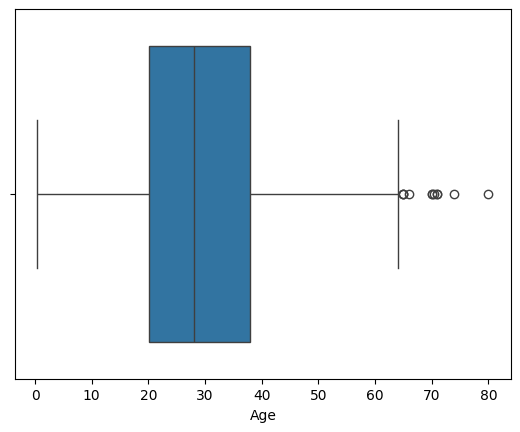

In [7]:
# Outliers with boxplot
sns.boxplot(x=df['Age'])
plt.show()

In [8]:
### Detcting Outliers
## Finding Thresholds
## First we need to find quartiles so we can calculate IQR
q1 = df['Age'].quantile(0.25)
print(f'25th percentile = {q1}')
q3 = df['Age'].quantile(0.75)
print(f'75th percentile = {q3}')

25th percentile = 20.125
75th percentile = 38.0


In [9]:
# Finding iqr and calculating lower and upper limit 
iqr = q3-q1 
low_limit = q1 - 1.5*iqr
up_limit = q3 + 1.5*iqr
print(f'lower limit = {low_limit}\nupper limit = {up_limit} ')

lower limit = -6.6875
upper limit = 64.8125 


In [10]:
#Finding outliers with the limits
# Because low limit is below zero there is no data lower than the low limit
df.query('Age > @up_limit | Age < @low_limit')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
33,34,0,2,"Wheadon, Mr. Edward H",male,66.000,0,0,C.A. 24579,10.500,NaN,S
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.000,0,1,113509,61.979,B30,C
96,97,0,1,"Goldschmidt, Mr. George B",male,71.000,0,0,PC 17754,34.654,A5,C
116,117,0,3,"Connors, Mr. Patrick",male,70.500,0,0,370369,7.750,NaN,Q
280,281,0,3,"Duane, Mr. Frank",male,65.000,0,0,336439,7.750,NaN,Q
456,457,0,1,"Millet, Mr. Francis Davis",male,65.000,0,0,13509,26.550,E38,S
493,494,0,1,"Artagaveytia, Mr. Ramon",male,71.000,0,0,PC 17609,49.504,NaN,C
630,631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.000,0,0,27042,30.000,A23,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.000,0,0,C.A. 24580,10.500,NaN,S
745,746,0,1,"Crosby, Capt. Edward Gifford",male,70.000,1,1,WE/P 5735,71.000,B22,S


In [11]:
# Getting the index of outliers
df.query('Age > @up_limit | Age < @low_limit').index

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [12]:
# For finding are there any outliers True or False
# Are there any data lower than the low limit or upper than up limit
df.query('Age > @up_limit | Age < @low_limit').any(axis=None)

True

In [13]:
# Are there any data lower than the low limit
df.query('Age < @low_limit').any(axis=None)

False

### Lecture 2
1. Creating functions for outliers
- Feature Engineering , Data Pre-processing should be on script level
- It should run on os level and complete all the data pre processing
- So we should do everything programmaticly with functions on script level


In [14]:
# Find outlier thresholds
# q1 and q3 values could change (5-95 or 1-99)
# The instructor prefers 5-95 but in lit. it is 25-75
def outlier_thresholds(df, col_name, q1 = 0.25, q3 = 0.75 ):
    quartile1 = df[col_name].quantile(q1)
    quartile3 = df[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * interquantile_range
    lower_limit = quartile1- 1.5 * interquantile_range
    return lower_limit,upper_limit

In [15]:
outlier_thresholds(df,'Age')


(-6.6875, 64.8125)

In [16]:
outlier_thresholds(df,'Fare')

(-26.724, 65.6344)

In [17]:
low, up = outlier_thresholds(df,'Fare')
df.query('Fare > @up | Fare < @low')['Fare'].describe()

count   116.000
mean    128.292
std      84.637
min      66.600
25%      78.190
50%      90.000
75%     147.778
max     512.329
Name: Fare, dtype: float64

In [18]:
def check_outlier(df, col_name):
    low_limit, up_limit = outlier_thresholds(df,col_name)
    return df[(df[col_name] > up_limit )| (df[col_name] < low_limit)].any(axis=None)


In [19]:
check_outlier(df, 'Age')

True

In [20]:
check_outlier(df, 'Fare')

True

### Lecture 3
- We need to check_outlier for every variable how can we do it programmaticly
- How can we get numerical variables, categorical variables etc.

In [21]:
# Categoric -> Sex
# Numerical -> Fare
# There are some variables in this dataset that is numerical but actually categorical
# seems like numerical categorical variables -> Pclass(1,2,3), Survived(0,1)
# SibSp(Number of siblings) could be assessed as categorical, open to interepretation, not final
# Another type is categorical but not carrying information, has so many classes this one called cardinal variables
# seems like categorical but cardinal variables ->Name, Ticket, cabin- no measurement value- not categoric because has as many category classes as sample numbers
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [22]:
# With this function we can get variable types mentioned above
# Categoric
# Numerical
# seems like numerical categorical variables
# seems like categorical but cardinal variables
def get_col_names(df, categoric_threshold = 10, cardinal_threshold = 20):
    """
    Gives the actual categorical, actual numerical and seems categorical but cardinal variable names
    Note: Categoric variables includes seems like numerical categorical variables

    Parameters
    -------
    df: dataframe- Dataframe to get variable names    
    categoric_threshold: int, optional - numeric but categorical variables threshold value
    cardinal_threshold: int, optional - categoric but cardinal variables threshold value
    Note: Thresholds can change according to dataset
    Returns
    -------
    categoric_cols:list -List of cat variables
    num_cols:list - List of numerical variables
    cat_but_car: list - List of cardinal variables


    """
    # Getting the all look like categorical variables
    categorical_cols = [col for col in df.columns if df[col].dtypes == "O"]
    # Getting the seems like numerical but categorical variables
    # If class number (unique value) lower than categorical threshold it is a categorical variable not numerical
    num_but_cat = [col for col in df.columns if df[col].nunique() < categoric_threshold and df[col].dtypes != "O"]
    # Getting the seems like categorical but cardinal variables
    # If class number (unique value) bigger than cardinal threshold it is a cardinal variable not categorical
    cat_but_car = [col for col in df.columns if df[col].nunique() > cardinal_threshold and df[col].dtypes == "O"]
    # Getting the actual categorical variables added the numerical categorical and substract cardinal categorical variables
    categorical_cols = categorical_cols + num_but_cat
    categorical_cols = [col for col in categorical_cols if col not in cat_but_car]
    
    # Getting the all look like numerical variables
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    #Getting the actual numerical variables by substracting numeric categorical variables
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Observations:{df.shape[0]}")
    print(f"Variables:{df.shape[1]}")
    print(f"categorical columns:{len(categorical_cols)}")
    print(f"numerical columns:{len(num_cols)}")
    print(f"cardinal columns:{len(cat_but_car)}")
    print(f"numeric but categorical variables:{len(num_but_cat)}")
    # num_but_cat is in categorical variables
    return categorical_cols, num_cols, cat_but_car



In [23]:
categorical_cols, num_cols, cat_but_car = get_col_names(df)

Observations:891
Variables:12
categorical columns:6
numerical columns:3
cardinal columns:3
numeric but categorical variables:4


In [24]:
# All  numerical categorical variables catched
# There are two open to interpreation var.:'SibSp'  'Parch'
# We can change that by changing the thresholds but with this thresholds they are categorical not numerical
categorical_cols

['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch']

In [25]:
# We classisifed variables programmaticly 
# Sometimes we cant understand this in first look or there are so many variables
# Making this with a function is so much easier

In [26]:
# Id and dates are the exception
# Not control this in the function because it will reduce readability of the function
num_cols

['PassengerId', 'Age', 'Fare']

In [27]:
# Redefining num_col here
num_cols = [col for col in num_cols if col not in "PassengerId"]
print(num_cols)

['Age', 'Fare']


In [28]:
# cardinal variables are non functional we dont really need it

In [29]:
# Find out if there is outlier in numerical columns
for col in num_cols:
    print(col, check_outlier(df,col))

Age True
Fare True


In [30]:
# Loading big dataset
df_big =load_dataset('data/application_train.csv')

In [31]:
# There can be binary encoded var. -> Categorical var
# We find all numerical and categorical var. 
categorical_cols, num_cols, cat_but_car = get_col_names(df_big)

Observations:307511
Variables:122
categorical columns:54
numerical columns:67
cardinal columns:1
numeric but categorical variables:39


In [32]:
# Excluding ID from num cols
num_cols = [col for col in num_cols if col not in "SK_ID_CURR"]


In [33]:
# Find out if there is outlier in numerical columns
# Dont forget q1 and q3 are 0.25 snd 0.75
# Because of that most of them has outliers
for col in num_cols:
    print(col, check_outlier(df_big,col))

CNT_CHILDREN True
AMT_INCOME_TOTAL True
AMT_CREDIT True
AMT_ANNUITY True
AMT_GOODS_PRICE True


REGION_POPULATION_RELATIVE True
DAYS_BIRTH False
DAYS_EMPLOYED True
DAYS_REGISTRATION True
DAYS_ID_PUBLISH False
OWN_CAR_AGE True
CNT_FAM_MEMBERS True
HOUR_APPR_PROCESS_START True
EXT_SOURCE_1 False
EXT_SOURCE_2 False
EXT_SOURCE_3 False
APARTMENTS_AVG True
BASEMENTAREA_AVG True
YEARS_BEGINEXPLUATATION_AVG True
YEARS_BUILD_AVG True
COMMONAREA_AVG True
ELEVATORS_AVG True
ENTRANCES_AVG True
FLOORSMAX_AVG True
FLOORSMIN_AVG True
LANDAREA_AVG True
LIVINGAPARTMENTS_AVG True
LIVINGAREA_AVG True
NONLIVINGAPARTMENTS_AVG True
NONLIVINGAREA_AVG True
APARTMENTS_MODE True
BASEMENTAREA_MODE True
YEARS_BEGINEXPLUATATION_MODE True
YEARS_BUILD_MODE True
COMMONAREA_MODE True
ELEVATORS_MODE True
ENTRANCES_MODE True
FLOORSMAX_MODE True
FLOORSMIN_MODE True
LANDAREA_MODE True
LIVINGAPARTMENTS_MODE True
LIVINGAREA_MODE True
NONLIVINGAPARTMENTS_MODE True
NONLIVINGAREA_MODE True
APARTMENTS_MEDI True
BASEMENTAREA_MEDI True
YEARS_BEGINEXPLUATATION_MEDI True
YEARS_BUILD_MEDI True
COMMONAREA_MEDI True
ELEVATORS_ME

### Lecture 4
- Accessing to outliers

In [34]:
# Show outliers if outliers bigger than 10 show first five else show all
# To observate,look outliers 
# Get outliers index is optional
# An analyze function to understand outliers but if you want it can get outlier index
def show_outliers(df, col_name, index = False ):
    # get outlier thresholds
    low, up = outlier_thresholds(df, col_name)
   
    # Show the outliers
    #if outliers bigger than 10 show first five 
    if len(df[(df[col_name] < low) | (df[col_name] > up)]) > 10:
        print(df[(df[col_name] < low) | (df[col_name] > up)].head())
    #else show all
    else:
        print(df[(df[col_name] < low) | (df[col_name] > up)])
    # İf index is true return outlier indexes
    if index:
        return df[(df[col_name] < low) | (df[col_name] > up)].index
    

In [35]:
# Get outliers for given column as a dataframe
def get_outliers(df, col_name):
    # get outlier thresholds
    low, up = outlier_thresholds(df, col_name)
    # Return the outliers
    return df.loc[((df[col_name] < low) | (df[col_name] > up)), col_name]

In [36]:
get_outliers(df, 'Age').describe()

count   11.000
mean    69.773
std      4.568
min     65.000
25%     65.500
50%     70.000
75%     71.000
max     80.000
Name: Age, dtype: float64

In [37]:
age_outlier_index = show_outliers(df, 'Age', True)

     PassengerId  Survived  Pclass                            Name   Sex    Age  SibSp  Parch      Ticket   Fare Cabin Embarked
33            34         0       2           Wheadon, Mr. Edward H  male 66.000      0      0  C.A. 24579 10.500   NaN        S
54            55         0       1  Ostby, Mr. Engelhart Cornelius  male 65.000      0      1      113509 61.979   B30        C
96            97         0       1       Goldschmidt, Mr. George B  male 71.000      0      0    PC 17754 34.654    A5        C
116          117         0       3            Connors, Mr. Patrick  male 70.500      0      0      370369  7.750   NaN        Q
280          281         0       3                Duane, Mr. Frank  male 65.000      0      0      336439  7.750   NaN        Q


In [38]:
# We catched the outliers
age_outlier_index

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

In [39]:
# Now we can transform outliers or ignore it
# Tree methods insentitive to outliers, missing values so in these methods outliers and missing values are ignored

### What we did so far ?
1. Calculating outlier threshold(outlier_thresholds)
2. Find if there is any outlier(check_outlier)
3. Catched the outliers(grab_outliers)

### Lecture 5
- Solving the outlier problem

In [40]:
# To understand the outliers
df.iloc[show_outliers(df,'Fare', True)]['Fare'].describe()

    PassengerId  Survived  Pclass                                               Name     Sex    Age  SibSp  Parch    Ticket    Fare        Cabin Embarked
1             2         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female 38.000      1      0  PC 17599  71.283          C85        C
27           28         0       1                     Fortune, Mr. Charles Alexander    male 19.000      3      2     19950 263.000  C23 C25 C27        S
31           32         1       1     Spencer, Mrs. William Augustus (Marie Eugenie)  female    NaN      1      0  PC 17569 146.521          B78        C
34           35         0       1                            Meyer, Mr. Edgar Joseph    male 28.000      1      0  PC 17604  82.171          NaN        C
52           53         1       1           Harper, Mrs. Henry Sleeper (Myna Haxtun)  female 49.000      1      0  PC 17572  76.729          D33        C


count   116.000
mean    128.292
std      84.637
min      66.600
25%      78.190
50%      90.000
75%     147.778
max     512.329
Name: Fare, dtype: float64

In [41]:
get_outliers(df,'Age').describe()

count   11.000
mean    69.773
std      4.568
min     65.000
25%     65.500
50%     70.000
75%     71.000
max     80.000
Name: Age, dtype: float64

In [42]:
low, up =outlier_thresholds(df,'Fare')
low,up

(-26.724, 65.6344)

In [43]:
df.shape

(891, 12)

In [44]:
df.query('Fare > @low & Fare < @up').shape

(775, 12)

In [45]:
low, up =outlier_thresholds(df,'Age')
low,up


(-6.6875, 64.8125)

In [46]:
df.shape

(891, 12)

In [47]:
# Because of the missing values outliers + non-outliers != 891
df.query('Age < @up').shape

(703, 12)

##### Delete outliers


In [48]:
# Returns dataframe without outliers

def remove_outlier(df, col_names):
    thresholds = []
    # Find threshold for each column
    for col_num in range(len(col_names)):
        low, up = outlier_thresholds(df,col_names[col_num])
        thresholds.append((low,up))
    print(thresholds)
    # For each column get the dataframe without that column's outliers
    # Get the dataframe that inside of the thresholds sequentially for each column
    # First we get the dataframe without first column's outliers then in that dataframe we get the dataframe without second column's outliers... 
    for col_num in range(len(col_names)):
        df = df[(df[col_names[col_num]] > thresholds[col_num][0]) & (df[col_names[col_num]]  < thresholds[col_num][1])]
    return df

In [49]:
categorical_cols, num_cols, cat_but_car = get_col_names(df)

num_cols = [col for col in num_cols if col not in "PassengerId"]

remove_outlier(df, num_cols).shape


Observations:891
Variables:12
categorical columns:6
numerical columns:3
cardinal columns:3
numeric but categorical variables:4
[(-6.6875, 64.8125), (-26.724, 65.6344)]


(603, 12)

#### Re-assign the outliers with thresholds
- Prevent data loss
- When we delete for one column's value we lose all other column's values. So we could choose to dominate the outliers instead of deleting complete row

In [50]:
# Finding thresholds
low, up = outlier_thresholds(df, 'Fare')

In [51]:
# Changing outliers with thresholds
df.loc[((df['Fare'] < low),'Fare')] = low

In [52]:
df.loc[((df['Fare'] > up),'Fare')] = up

In [53]:
# Empty because we replaced the outliers with thresholds
df.loc[((df['Fare'] < low) | (df['Fare'] > up),'Fare')]

Series([], Name: Fare, dtype: float64)

In [54]:
# Replacing outliers with thresholds
def replace_outliers_with_thresholds(df, col_name):
    low_limit, up_limit = outlier_thresholds(df, col_name)
    df.loc[((df[col_name] < low_limit),col_name)] = low_limit
    df.loc[((df[col_name] > up_limit),col_name)] = up_limit

In [55]:
# Handling outliers programaticly
df = load_dataset()
categorical_cols, num_cols, cat_but_car = get_col_names(df)

num_cols = [col for col in num_cols if col not in "PassengerId"]

for col in num_cols:
    print(col, check_outlier(df,col))

for col in num_cols:
    replace_outliers_with_thresholds(df,col)

for col in num_cols:
    print(col, check_outlier(df,col))

Observations:891
Variables:12
categorical columns:6
numerical columns:3
cardinal columns:3
numeric but categorical variables:4
Age True
Fare True
Age False
Fare False


### Lecture 6
- Multivariate Outlier Analysis : Local Outlier Factor
- One variable might not be outlier by itself but can be outlier with another variable 
- For example age and number of marriages,
age 17 is not a outlier by itself and 3 marriages not an outlier by itself but when 3 marriages  in age of 17 is a outlier


### LOF (Local Outlier Factor)
- LOF is a Multivariate Outlier Detection Method
- Allows us to define outliers by scoring observations based on density at their location
- Local density of a point means the neighborhood arund that point
- If one point has significantly lower density than its neighbors it is in more sparse location so this point can be an outlier
- LOF method allow us to calculate distance score for the observations according to neighborhood density
- If the score closer the 1 is better. The more observation get far from 1 the probability of that observation being an outlier increases
- We can intervine in this method by determining the threshold. We can determine the threshold as 5 so only the score bigger than 5 defined as outlier 

In [58]:
## Example 
# Loading the dataser
df = sns.load_dataset('diamonds') 
# Chosing only numerical variables
df = df.select_dtypes(include=['float64','int64'])
# Dropping missing values
df = df.dropna()
df.head()

,carat,depth,table,price,x,y,z
0,0.230,61.500,55.000,326,3.950,3.980,2.430
1,0.210,59.800,61.000,326,3.890,3.840,2.310
2,0.230,56.900,65.000,327,4.050,4.070,2.310
3,0.290,62.400,58.000,334,4.200,4.230,2.630
4,0.310,63.300,58.000,335,4.340,4.350,2.750


In [59]:
# Checking outliers
for col in df.columns:
    print(col,check_outlier(df, col))

carat True
depth True
table True
price True
x True
y True
z True


In [61]:
# Looking for outliers in carat variable
get_outliers(df,'carat').shape

(1889,)

In [62]:
# Looking for outliers in depth variable
get_outliers(df,'depth').shape

(2545,)

In [ ]:
#####################
# IMPORTANT
# Because we used 25/75 threshold there are to many outliers
# If we delete or replace this it would cause data loss or we would add noise
# For that reason we  use 95/5 or 99/1, just handling very extreme data 
# If you use tree methods you can choose to not touch it 

In [63]:
# When we look just one variable there is too much variables
# Lets look at the multivariate outliers, LOC
# default neighbor value is 20
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
# We use negative values because it is easier to read in elbow method
# We just changed the sign instead of 1 it is -1
df_scores = clf.negative_outlier_factor_

In [64]:
df_scores[0:5]

array([-1.58352526, -1.59732899, -1.62278873, -1.33002541, -1.30712521])

In [65]:
# The ones closer the -1 is the best ones
# The ones farther away from the -1 is the worsr ones
np.sort(df_scores)[0:5]

array([-8.60430658, -8.20889984, -5.86084355, -4.98415175, -4.81502092])

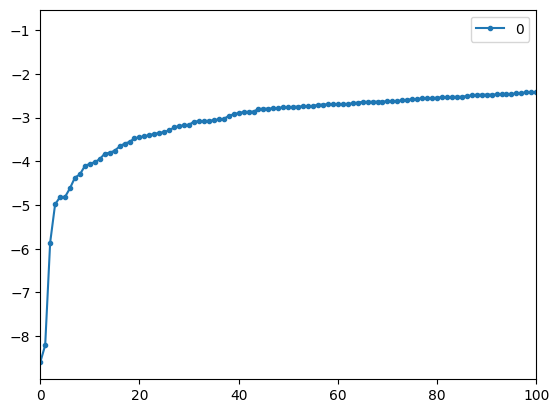

In [69]:
# How to choose threshold?
# Elbow method
# Where the slope change is last drastic in scores we can determine that as threshold
# Where the last marginal change hapenned
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0,100], style='.-')
plt.show()

In [71]:
# I can chose the third score as the threshold because the last drastic change hapenned there
th = np.sort(df_scores)[3]
th

-4.984151747711709

In [ ]:
# We solve the main problem of the outliers detection which is determine the threshold
# Before we determine the threshold for every variable 
# Now for LOF method,  which will evaluate all variables at the same time, we determined the threshold in the Lof scores 

In [74]:
# Using this threshold i can choose the outliers
# 3 outliers found
# When i look at the variables indivudally there were about two thousand outliers
# But in  multivariate effect (LOC) there is only 3
df[df_scores<th]

,carat,depth,table,price,x,y,z
41918,1.030,78.200,54.000,1262,5.720,5.590,4.420
48410,0.510,61.800,54.700,1970,5.120,5.150,31.800
49189,0.510,61.800,55.000,2075,5.150,31.800,5.120


In [75]:
df.describe([0.01, 0.05, 0.75, 0.90, 0.99 ]).T

,count,mean,std,min,1%,5%,50%,75%,90%,99%,max
carat,53940.000,0.798,0.474,0.200,0.240,0.300,0.700,1.040,1.510,2.180,5.010
depth,53940.000,61.749,1.433,43.000,57.900,59.300,61.800,62.500,63.300,65.600,79.000
table,53940.000,57.457,2.234,43.000,53.000,54.000,57.000,59.000,60.000,64.000,95.000
price,53940.000,3932.800,3989.440,326.000,429.000,544.000,2401.000,5324.250,9821.000,17378.220,18823.000
x,53940.000,5.731,1.122,0.000,4.020,4.290,5.700,6.540,7.310,8.360,10.740
y,53940.000,5.735,1.142,0.000,4.040,4.300,5.710,6.540,7.300,8.340,58.900
z,53940.000,3.539,0.706,0.000,2.480,2.650,3.530,4.040,4.520,5.150,31.800


In [ ]:
# why depth 78 here but not 79 
# the reason can be the price and depth or carate and depth
# We can see the multivariate effect is the important thing here
# In second row all the variable were avarege but z was the maximum value
# So it detected as an outlier
# This is the multivariate effect

- How to suppress outliers?
- Supress the outliers with what ?
We can choose one average observation to replace the outliers but If we have too many outliers it will duplicate the data. Because we are changing the observation not the cell. We would be adding noise to the data. It would cause problems
- For that reason we should look at the outliers individually replace one cell. 
- But there is so many in individually
- That because of the threshold if we choose the very extreme(99-1 / 95-5) we will catch the same ones as LOC 
- And we can replace them with the thresholds
- In conclusion we will reduce the outlier number by doing that and it is better than producing duplicate observations
- In multivariate analyze If the observation number is big we can not use supressing. If the number is few that outliers should be removed fromed dataset


- If we are working with trees we will not touch the outliers or we can only handle the outliers individually at extreme (99-1) 


- In linear methods outlier problem is real. If outliers is few we can choose deleting instead of duplicating.We can choose supressing individually instead of duplicating but we should still look for outliers in the extreme 